In [42]:
# Jean setup:
import findspark
findspark.init()

pathBme = "C:\SofiaAirQuality\OneMonthBme"
pathSds = "C:\SofiaAirQuality\OneMonthSds"

In [ ]:
# Luiz setup
pathBme = "/home/luiz/SofiaAirQuality/OneMonthBme"
pathSds = "/home/luiz/SofiaAirQuality/OneMonthSds"

In [105]:
import pyspark
from pyspark.sql import *
import pyspark.sql.functions as f

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType, StructType
from pyspark.sql.functions import col, unix_timestamp

import matplotlib.pyplot as plt

In [250]:
# Configuração
spark = SparkSession \
    .builder \
    .master("local[8]") \
    .appName("tp_final_jean_luiz").getOrCreate()

df1Schema = StructType() \
    .add("_c0", "integer") \
    .add("sensor_id", "integer") \
    .add("location", "integer") \
    .add("lat_1", "double") \
    .add("long_1", "double") \
    .add("timestamp", "timestamp") \
    .add("pressure", "double") \
    .add("temperature", "double") \
    .add("humidity", "double") \

df2Schema = StructType() \
    .add("_c0", "integer") \
    .add("sensor_id", "integer") \
    .add("location", "integer") \
    .add("lat_2", "double") \
    .add("long_2", "double") \
    .add("timestamp", "timestamp") \
    .add("P1", "double") \
    .add("P2", "double") \

df1 = spark.read.schema(df1Schema).format("csv").load(pathBme, header=True)
df2 = spark.read.schema(df2Schema).format("csv").load(pathSds, header=True)

In [251]:
df1 = df1 \
    .withColumn("df1Location", df1.location) \
    .withColumn("df1Timestamp", df1.timestamp) \
    .withColumn("df1Id", df1.sensor_id).limit(5000)

df2 = df2 \
    .withColumn("df2Location", df2.location) \
    .withColumn("df2Timestamp", df2.timestamp) \
    .withColumn("df2Id", df2.sensor_id).limit(5000)

In [252]:
df1.count()

5000

In [253]:
df2.count()

5000

In [254]:
joined = df1.join(
  df2,
  f.expr("""
    df1Location = df2Location AND
    df1Timestamp <= df2Timestamp + interval 1 minutes AND
    df1Timestamp >= df2Timestamp - interval 1 minutes
    """)
)

In [255]:
joined.count()

3140

In [256]:
# TODO talvez tenha um jeito melhor de fazer isso

joinedWithoutDuplicates = joined.dropDuplicates(['df1Id', 'df1Timestamp'])

In [257]:
joinedWithoutDuplicates.count()

3140

In [258]:
columnsOfInterest = ['df1Id', 'df1Timestamp', 'df1Location', 'df2Id', 'df2Timestamp', 'df2Location', 'pressure', 'temperature', 'humidity', 'P1', 'P2']
joinedWithoutDuplicates.filter(joinedWithoutDuplicates.df1Id == 2266).select(*columnsOfInterest).show(100)

+-----+-------------------+-----------+-----+-------------------+-----------+--------+-----------+--------+-----+----+
|df1Id|       df1Timestamp|df1Location|df2Id|       df2Timestamp|df2Location|pressure|temperature|humidity|   P1|  P2|
+-----+-------------------+-----------+-----+-------------------+-----------+--------+-----------+--------+-----+----+
| 2266|2017-07-01 00:00:07|       1140| 2265|2017-07-01 00:00:06|       1140|95270.27|      23.46|   62.48|25.33|6.57|
| 2266|2017-07-01 00:02:33|       1140| 2265|2017-07-01 00:02:33|       1140|95266.66|      23.37|    63.4| 15.7|6.27|
| 2266|2017-07-01 00:05:00|       1140| 2265|2017-07-01 00:04:59|       1140|95258.14|      23.37|   63.22|18.17| 6.6|
| 2266|2017-07-01 00:07:26|       1140| 2265|2017-07-01 00:07:26|       1140|95267.81|      23.23|   63.07| 15.9|6.83|
| 2266|2017-07-01 00:09:53|       1140| 2265|2017-07-01 00:09:52|       1140|95267.84|      23.25|   63.37|13.67|5.97|
| 2266|2017-07-01 00:12:19|       1140| 2265|201

In [259]:
tmpp = joinedWithoutDuplicates \
    .withColumn("timestampDelta", joinedWithoutDuplicates.df2Timestamp.cast("long") - joinedWithoutDuplicates.df1Timestamp.cast("long")) \
    .withColumn("idDifference", joinedWithoutDuplicates.df2Id - joinedWithoutDuplicates.df1Id)

tmpp \
    .select("timestampDelta") \
    .agg(f.avg("timestampDelta")) \
    .show()

tmpp \
    .agg(f.avg("idDifference")) \
    .show()

+-------------------+
|avg(timestampDelta)|
+-------------------+
|-1.1127388535031848|
+-------------------+

+-----------------+
|avg(idDifference)|
+-----------------+
|             -1.0|
+-----------------+



In [260]:
columnsOfInterest = ['df1Id', 'df1Timestamp', 'df1Location', 'df2Id', 'df2Timestamp', 'df2Location', 'pressure', 'temperature', 'humidity', 'P1', 'P2']
joinedWithoutDuplicates.select(*columnsOfInterest).show(100)

+-----+-------------------+-----------+-----+-------------------+-----------+--------+-----------+--------+-----+-----+
|df1Id|       df1Timestamp|df1Location|df2Id|       df2Timestamp|df2Location|pressure|temperature|humidity|   P1|   P2|
+-----+-------------------+-----------+-----+-------------------+-----------+--------+-----------+--------+-----+-----+
| 2266|2017-07-01 00:00:07|       1140| 2265|2017-07-01 00:00:06|       1140|95270.27|      23.46|   62.48|25.33| 6.57|
| 2292|2017-07-01 00:00:08|       1154| 2291|2017-07-01 00:00:07|       1154|94355.83|      23.06|   59.46|15.07| 9.67|
| 3096|2017-07-01 00:00:10|       1558| 3095|2017-07-01 00:00:10|       1558|95155.81|      26.53|   44.38| 15.6| 6.43|
| 3428|2017-07-01 00:00:12|       1727| 3427|2017-07-01 00:00:12|       1727|94679.57|      28.34|   38.28|13.73| 6.43|
| 3472|2017-07-01 00:00:13|       1750| 3471|2017-07-01 00:00:12|       1750|94327.88|      26.31|   46.37| 20.9|10.67|
| 1952|2017-07-01 00:00:13|        976| 

C:\Users\jeang\AppData\Local\Temp/ipykernel_4000/3667947647.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
C:\Users\jeang\AppData\Local\Temp/ipykernel_4000/3667947647.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


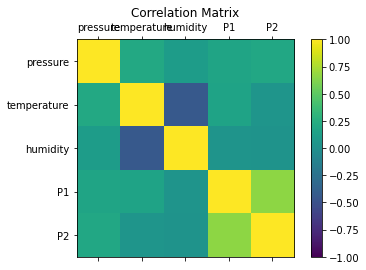

+-------------------+--------------------+--------------------+--------------------+--------------------+
|           pressure|         temperature|            humidity|                  P1|                  P2|
+-------------------+--------------------+--------------------+--------------------+--------------------+
|                1.0| 0.20423683037764828| 0.10213356443987771| 0.16490204404499703| 0.20265069071817488|
|0.20423683037764828|                 1.0|-0.43981674127255627| 0.15842748957536176|0.041349662957927115|
|0.10213356443987771|-0.43981674127255627|                 1.0|0.031638729774334726| 0.02761352684519053|
|0.16490204404499703| 0.15842748957536176|0.031638729774334726|                 1.0|  0.6564271690798371|
|0.20265069071817488|0.041349662957927115| 0.02761352684519053|  0.6564271690798371|                 1.0|
+-------------------+--------------------+--------------------+--------------------+--------------------+



In [209]:
# 1. Realizar uma análise da correlação entre os atributos presentes na base de dados 
# (pressão, temperatura, umidade, P1 (PM10) e P2 (PM2,5)).

# Filtrando apenas as colunas desejadas
columns = ['pressure','temperature','humidity', 'P1', 'P2']
df_filtered = joinedWithoutDuplicates.select(*columns)
df_filtered = df_filtered.filter(df_filtered.pressure.isNotNull())
df_filtered = df_filtered.filter(df_filtered.temperature.isNotNull())
df_filtered = df_filtered.filter(df_filtered.humidity.isNotNull())

# Criando coluna de vector
vector_column = "vector_column"
assembler = VectorAssembler(inputCols=df_filtered.columns, outputCol=vector_column)
df_vector = assembler.transform(df_filtered).select(vector_column)

# Obtendo matriz de correlação
matrix = Correlation.corr(df_vector, vector_column).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

# Plotando
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()
plot_corr_matrix(corrmatrix, columns, 234)

spark.createDataFrame(corrmatrix,columns).show() # testando

In [143]:
spark.createDataFrame(corrmatrix,columns).write.csv('correlation.csv', header=True)

In [ ]:
# Questão 2

In [264]:
# Questão 3
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GeneralizedLinearRegression

# TODO replicar para P2
target="P1"

originalDf = joinedWithoutDuplicates \
    .withColumn("df1Timestamp", unix_timestamp("df1Timestamp"))\
    .withColumn("df2Timestamp", unix_timestamp("df2Timestamp"))
    
inputCols = [
    'df1Id', 'df1Timestamp', 'df1Location', 'lat_1', 'long_1', 
     'df2Id', 'df2Timestamp', 'df2Location', 'lat_2', 'long_2', 
     'pressure', 'temperature', 'humidity', 
     'P2'
]

assembler = VectorAssembler(inputCols=inputCols, outputCol="features")
transformedDf = assembler.transform(originalDf)

[train, test] = transformedDf.randomSplit([0.8, 0.2])

# classifier = NaiveBayes(labelCol=target, featuresCol="features")
classifier = LinearRegression(labelCol=target, featuresCol="features")
# classifier =  RandomForestRegressor(labelCol=target, featuresCol="features")
# classifier = GeneralizedLinearRegression(labelCol=target,featuresCol="features")

pipeline = Pipeline(stages=[classifier])

model = pipeline.fit(train)

predictions = model.transform(test)

evaluation = MulticlassClassificationEvaluator(labelCol=target, predictionCol="prediction", metricName="accuracy")
accuracy = evaluation.evaluate(predictions)

print("accuracy = %s" % accuracy)
predictions.select(target,"prediction").show()

accuracy = 0.0
+-----+------------------+
|   P1|        prediction|
+-----+------------------+
| 4.23| 6.495370789285516|
|12.77|14.638420878145553|
| 5.27|10.953749282569333|
|16.47|16.184161324890738|
|  6.6|11.485230493475683|
|19.03|14.242459849541774|
| 22.5|13.511094119363406|
|14.93|15.908874969718454|
|13.83|17.629436809482286|
| 13.1|14.724801479285816|
|12.33|11.400005001109093|
| 12.8|17.896204325923463|
| 8.23|12.271219258320343|
| 21.2|18.613820901256986|
|10.93|14.336383924855909|
|15.47|12.609055774060835|
|28.83|21.060742772599042|
|14.23| 12.03572121002071|
|13.13| 14.36151058608084|
| 14.0|14.211405914997158|
+-----+------------------+
only showing top 20 rows

